# Hodgkin Huxley Basics

Simple set of simulations to demonstrate functionality of the Hodgkin Huxley model. The model itself is stored in `hh_neuron.py`

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Define Hodgkin Huxley Neuron Model

In [2]:
class hh_neuron:

    def __init__(self,dt):
        self.Ek  , self.gk  = -12 , 36
        self.Ena , self.gna = 115 , 120
        self.El  , self.gl  = 10.6 , 0.3
        self.C   = 1

        self.v   = 0
        self.m   = self.alpha_m() / (self.alpha_m() + self.beta_m() )
        self.h   = self.alpha_h() / (self.alpha_h() + self.beta_h() )
        self.n   = self.alpha_n() / (self.alpha_n() + self.beta_n() )

        self.dt = dt

    def alpha_m(self):
        return (2.5-0.1*self.v)/(np.exp(2.5-0.1*self.v)-1)
    def beta_m(self):
        return 4*np.exp(-self.v/18)
    def alpha_h(self):
        return 0.07*np.exp(-self.v/20)
    def beta_h(self):
        return 1/(np.exp(3-0.1*self.v)+1)
    def alpha_n(self):
        return (0.1-0.01*self.v)/(np.exp(1-0.1*self.v)-1)
    def beta_n(self): 
        return 0.125*np.exp(-self.v/80)

    def update(self , I_stim):
        I_na = self.gna * (self.m**3) * self.h * (self.v-self.Ena)
        I_k  = self.gk  * (self.n**4)          * (self.v-self.Ek)
        I_l  = self.gl                         * (self.v-self.El)
        I_mem = I_na + I_k + I_l

        dv = (I_stim - I_mem) / self.C
        dm = self.alpha_m() * (1-self.m) - self.beta_m()*self.m
        dh = self.alpha_h() * (1-self.h) - self.beta_h()*self.h
        dn = self.alpha_n() * (1-self.n) - self.beta_n()*self.n

        self.v += dv * self.dt
        self.m += dm * self.dt
        self.h += dh * self.dt
        self.n += dn * self.dt

        return self.v


## Model 1 - Action potential initiated by stimulus current

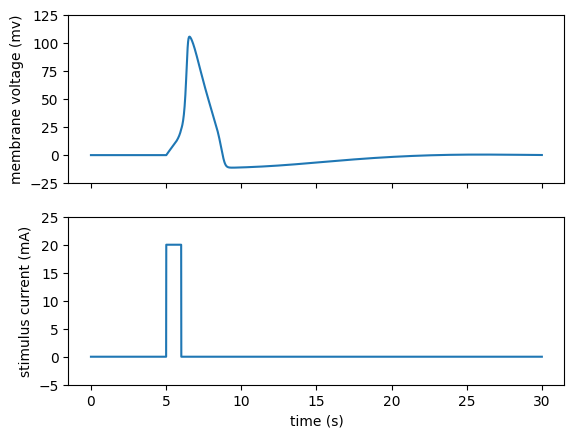

In [7]:
# DEFINE TIME #
dt   = 0.01
tmax = 30.0 
t    = np.arange(0.0, tmax, dt)

# DEFINE VECTORS #
v     = np.zeros(len(t))
Istim = np.zeros(len(t))

# DEFINE STIM STRENGTH AND DURATION #
tSTIM_START   =  5
tSTIM_DUR     =  1
STIM_STRENGTH = 20
Istim[ (t>tSTIM_START) & (t<=tSTIM_START+tSTIM_DUR) ] = STIM_STRENGTH

# CREATE A NEURON
n = hh_neuron(dt)

# SIMULATE THE NEURON
for i in range(len(t)-1): 
   
    v[i+1] = n.update(Istim[i])


# PLOT IT #
f,a = plt.subplots(2,1,sharex=True)
a[0].plot(t,v)
a[0].set_ylabel('membrane voltage (mv)')
a[0].set_ylim([-25,125])
a[1].plot(t,Istim)
a[1].set_xlabel('time (s)')
a[1].set_ylabel('stimulus current (mA)')
a[1].set_ylim([-5,25])

plt.show()


## Model 2 - Action potential not initiated by sub-threshold stimulus current

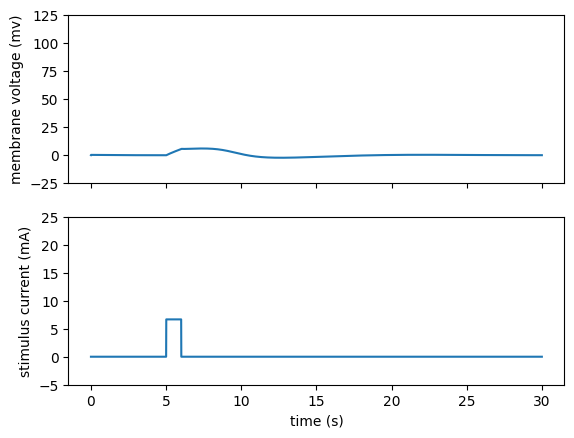

In [12]:
Istim = np.zeros(len(t))
Istim[ (t>tSTIM_START) & (t<=tSTIM_START+tSTIM_DUR) ] = STIM_STRENGTH/3

# # CREATE A NEURON
# n = hh_neuron(dt)

# SIMULATE THE NEURON
for i in range(len(t)-1): 
   
    v[i+1] = n.update(Istim[i])


# PLOT IT #
f,a = plt.subplots(2,1,sharex=True)
a[0].plot(t,v)
a[0].set_ylabel('membrane voltage (mv)')
a[0].set_ylim([-25,125])
a[1].plot(t,Istim)
a[1].set_xlabel('time (s)')
a[1].set_ylabel('stimulus current (mA)')
a[1].set_ylim([-5,25])

plt.show()


## Model 3 - Refractory Periods

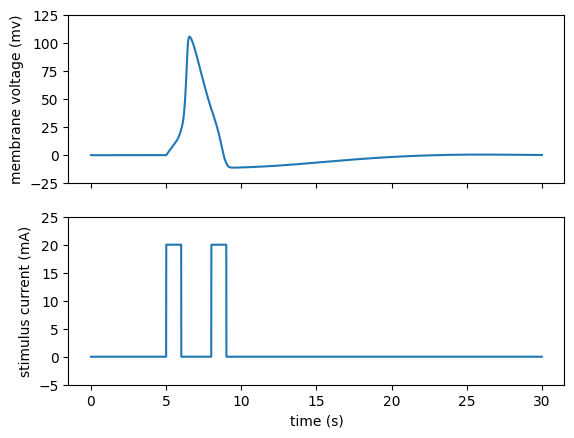

In [13]:
Istim = np.zeros(len(t))
Istim[ (t> 5) & (t<=6) ] = STIM_STRENGTH
Istim[ (t> 8) & (t<=9) ] = STIM_STRENGTH

# # CREATE A NEURON
# n = hh_neuron(dt)

# SIMULATE THE NEURON
for i in range(len(t)-1): 
   
    v[i+1] = n.update(Istim[i])


# PLOT IT #
f,a = plt.subplots(2,1,sharex=True)
a[0].plot(t,v)
a[0].set_ylabel('membrane voltage (mv)')
a[0].set_ylim([-25,125])
a[1].plot(t,Istim)
a[1].set_xlabel('time (s)')
a[1].set_ylabel('stimulus current (mA)')
a[1].set_ylim([-5,25])

plt.show()

## Model 4 - Fiber (multiple connected cells in a row)

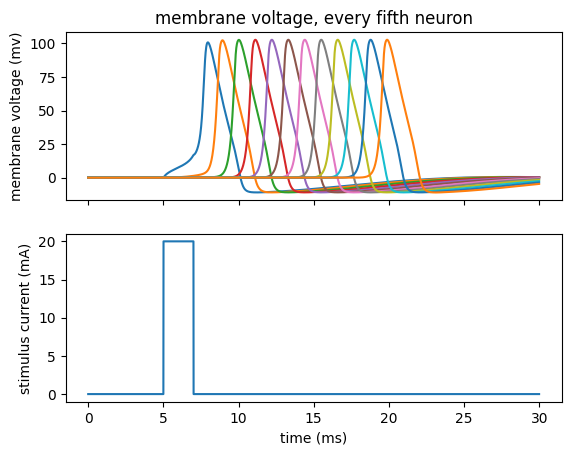

In [6]:
# DEFINE TIME #
dt   = 0.01
tmax = 30.0 
t = np.arange(0.0, tmax, dt)

# DEFINE NUM OF NEURONS # 
nCells = 60
my_neurons = [ hh_neuron(dt) for i in range(nCells) ]

# DEFINE CONDUCTION BETWEEN NEURONS
gConnect = 5

# DEFINE VECTORS #
v     = np.zeros((nCells,len(t)))
IStim = np.zeros(len(t))

# DEFINE STIM STRENGTH AND DURATION #
tSTIM_START = 5
tSTIM_DUR = 2
STIM_STRENGTH = 20
IStim[ (t>tSTIM_START) & (t<=tSTIM_START+tSTIM_DUR) ] = STIM_STRENGTH

# DEFINE MISC FUNCTIONS
def isFirstCell(j): return j == 0
def isLastCell(j):  return j == (nCells-1)

# RUN SIMULATION
for ith_time in range(len(t)-1): 

    for ith_neuron,n in enumerate(my_neurons):

        # DETERMINE STIMULUS CURRENT 
        Istimulus = 0 
        if isFirstCell( ith_neuron ):
            Istimulus = IStim[ ith_time ]
        
        # DETERMINE CURRENT FROM CELL TO THE LEFT #
        I_Left = 0
        if not isFirstCell(ith_neuron):
            I_Left = gConnect * (v[ith_neuron-1, ith_time] - v[ith_neuron, ith_time])
        
        # DETERMINE CURRENT FROM CELL TO THE RIGHT #
        I_Right = 0
        if not isLastCell(ith_neuron):  
            I_Right = gConnect * (v[ith_neuron+1, ith_time] - v[ith_neuron,ith_time])

        # UPDATE NEURON     
        v[ith_neuron,ith_time+1] = n.update(Istimulus+I_Left+I_Right)



# PLOT IT #
f,a = plt.subplots(2,1,sharex=True)
a[0].plot(t,v[0:nCells:5,:].T) 
a[0].set_ylabel('membrane voltage (mv)')
a[0].set_title('membrane voltage, every fifth neuron')
a[1].plot(t,IStim)
a[1].set_xlabel('time (ms)')
a[1].set_ylabel('stimulus current (mA)')
plt.show()